In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras

2022-11-19 18:00:04.867406: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-19 18:00:05.030419: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-19 18:00:05.030441: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-11-19 18:00:05.063205: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-19 18:00:06.127289: W tensorflow/stream_executor/platform/de

In [2]:
df = pd.read_csv("./data/fake_news_data.csv")

In [3]:
df.head()

,title,news_url,source_domain,tweet_num,real
0,Kandi Burruss Explodes Over Rape Accusation on...,http://toofab.com/2017/05/08/real-housewives-a...,toofab.com,42,1
1,People's Choice Awards 2018: The best red carp...,https://www.today.com/style/see-people-s-choic...,www.today.com,0,1
2,Sophia Bush Sends Sweet Birthday Message to 'O...,https://www.etonline.com/news/220806_sophia_bu...,www.etonline.com,63,1
3,Colombian singer Maluma sparks rumours of inap...,https://www.dailymail.co.uk/news/article-33655...,www.dailymail.co.uk,20,1
4,Gossip Girl 10 Years Later: How Upper East Sid...,https://www.zerchoo.com/entertainment/gossip-g...,www.zerchoo.com,38,1


In [4]:
df["real"].value_counts()

1    17441
0     5755
Name: real, dtype: int64

In [5]:
#Balance classes

df_fake = df.loc[df["real"] == 0]
df_real = df.loc[df["real"] == 1]

num_examples_per_class = min(len(df_fake),len(df_real))

df = pd.concat([df_fake.sample(num_examples_per_class), df_real.sample(num_examples_per_class)])

In [6]:
unique_domains = list(df["source_domain"].unique())
unique_titles = list(df["title"].unique())

In [7]:
num_words=10000
num_domains = len(unique_domains)

In [8]:

title_input = keras.Input(shape=(1,), name="title", dtype=tf.string)
source_domain_input = keras.Input(shape=(1,), name="domain", dtype=tf.string)
tweet_num_input = keras.Input(shape=(1,), name="num_tweets", dtype=tf.float32)

title_vectorizer = keras.layers.TextVectorization(max_tokens=num_words)
title_vectorizer.adapt(unique_titles)
title_vectorizer=title_vectorizer(title_input)

source_domain_lookup = keras.layers.StringLookup(vocabulary=unique_domains)(source_domain_input)

tweet_num_normalized = keras.layers.Normalization()
tweet_num_normalized.adapt(df["tweet_num"])
tweet_num_normalized = tweet_num_normalized(tweet_num_input)

2022-11-19 18:00:07.462640: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-11-19 18:00:07.462696: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2022-11-19 18:00:07.462725: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (rshps): /proc/driver/nvidia/version does not exist
2022-11-19 18:00:07.463078: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [9]:
title_embedding=keras.layers.Embedding(num_words+1, 64)(title_vectorizer)
source_domain_embedding = keras.layers.Embedding(num_domains+1, 64)(source_domain_lookup)


In [10]:
title_features = keras.layers.LSTM(128)(title_embedding)
source_domain_features = keras.layers.GlobalAveragePooling1D()(source_domain_embedding)

In [11]:
x = keras.layers.concatenate([title_features, source_domain_features, tweet_num_normalized])

In [12]:
output = keras.layers.Dense(1, name="real", activation="sigmoid")(x)

In [13]:
model = keras.Model(inputs=[title_input, source_domain_input, tweet_num_input], outputs=[output])

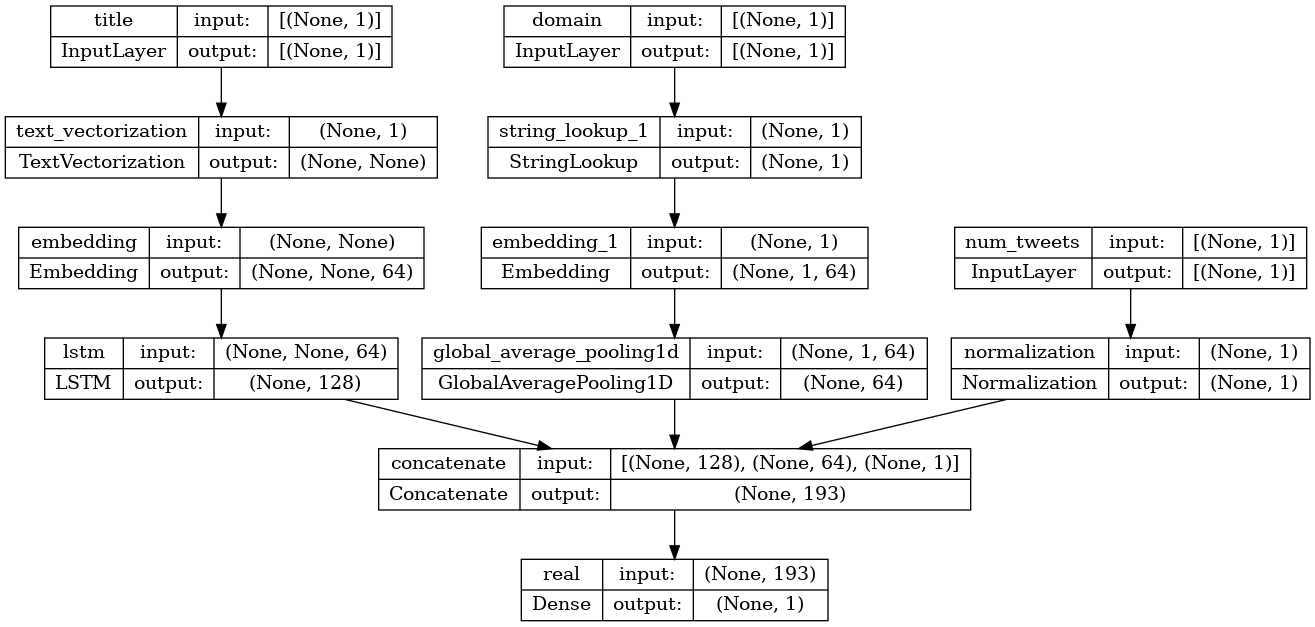

In [14]:
keras.utils.plot_model(model, show_shapes=True)

In [15]:
model.compile(
    optimizer=keras.optimizers.RMSprop(1e-3),
    loss=keras.losses.BinaryCrossentropy(),
    metrics=["binary_accuracy"]
)

In [16]:
import numpy as np

In [17]:
title_data = np.array((df["title"].astype(str)))
domain_data = np.array(df["source_domain"].astype(str))
tweet_num_data = np.array(df["tweet_num"])

target = np.array(df["real"].astype(int))

In [18]:
history = model.fit({"title":title_data, 
            "domain":domain_data,
            "num_tweets":tweet_num_data},
            {"real":target}, 
            epochs=15)

Epoch 1/15
360/360 [==============================] - 16s 34ms/step - loss: 0.4988 - binary_accuracy: 0.7639
Epoch 2/15
360/360 [==============================] - 11s 30ms/step - loss: 0.3636 - binary_accuracy: 0.8442
Epoch 3/15
360/360 [==============================] - 13s 35ms/step - loss: 0.3198 - binary_accuracy: 0.8679
Epoch 4/15
360/360 [==============================] - 12s 33ms/step - loss: 0.2955 - binary_accuracy: 0.8811
Epoch 5/15
360/360 [==============================] - 11s 30ms/step - loss: 0.2754 - binary_accuracy: 0.8910
Epoch 6/15
360/360 [==============================] - 11s 30ms/step - loss: 0.2630 - binary_accuracy: 0.8977
Epoch 7/15
360/360 [==============================] - 10s 26ms/step - loss: 0.2505 - binary_accuracy: 0.9041
Epoch 8/15
360/360 [==============================] - 10s 28ms/step - loss: 0.2390 - binary_accuracy: 0.9056
Epoch 9/15
360/360 [==============================] - 11s 31ms/step - loss: 0.2282 - binary_accuracy: 0.9129
Epoch 10/15
360/360

In [19]:
df_samples = df.sample(n=10)
sample_titles = np.array(df_samples["title"])
sample_domains = np.array(df_samples["source_domain"])
sample_tweet_nums = np.array(df_samples["tweet_num"])

In [20]:
input_example = {
    "title":sample_titles,
    "domain":sample_domains,
    "num_tweets":sample_tweet_nums
}

In [21]:
predictions = model.predict(input_example)

1/1 [==============================] - 0s 466ms/step


In [22]:
print("Predictions", ["real" if pred >= .5 else "fake" for pred in predictions])
print("Actual", ["real" if target == 1 else "fake" for target in df_samples["real"]])


Predictions ['real', 'fake', 'real', 'real', 'real', 'fake', 'real', 'fake', 'fake', 'fake']
Actual ['real', 'fake', 'real', 'real', 'fake', 'fake', 'real', 'fake', 'fake', 'fake']
